In [1]:
from torch.utils.data import IterableDataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator

import regex as re
import itertools
from itertools import islice

from torch import nn
import torch

from tqdm.notebook import tqdm
device = 'cuda'

S:\WENV_TORCHTEXT\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
S:\WENV_TORCHTEXT\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
def get_words_from_line(line):
    line = line.rstrip()
    yield '<s>'
    for m in re.finditer(r'[\p{L}0-9\*]+|\p{P}+', line):
        yield m.group(0).lower()
    yield '</s>'

def get_word_lines_from_file(file_name):
    with open(file_name, 'r', encoding='utf8') as fh:
        for line in fh:
            yield get_words_from_line(line)

def look_ahead_iterator(gen):
    prev2, prev1, next1, next2 = None, None, None, None
    for item in gen:
        if prev2 is not None and prev1 is not None and next1 is not None and next2 is not None:
            yield (prev2, prev1, next2, item, next1)
        prev2, prev1, next1, next2 = prev1, next1, next2, item

In [3]:
class FiveGrams(IterableDataset):
    def __init__(self, text_file, vocabulary_size):
        self.vocab = build_vocab_from_iterator(
            get_word_lines_from_file(text_file),
            max_tokens=vocabulary_size,
            specials=['<unk>']
        )
        self.vocab.set_default_index(self.vocab['<unk>'])
        self.vocabulary_size = vocabulary_size
        self.text_file = text_file

    def __iter__(self):
        return look_ahead_iterator(
            (self.vocab[t] for t in itertools.chain.from_iterable(get_word_lines_from_file(self.text_file)))
        )

In [4]:
class SimpleFiveGramNeuralLanguageModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super(SimpleFiveGramNeuralLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.linear1 = nn.Linear(embedding_size * 4, embedding_size)
        self.linear2 = nn.Linear(embedding_size, vocabulary_size)
        self.softmax = nn.Softmax(dim=1)
        self.embedding_size = embedding_size

    def forward(self, x):
        embeds = self.embedding(x).view(x.size(0), -1)
        out = self.linear1(embeds)
        out = self.linear2(out)
        return self.softmax(out)

In [5]:
def train(embed_size,vocab_size,num_epochs,batch_size,train_file_path):
    train_dataset = FiveGrams(train_file_path, vocab_size)
    model = SimpleFiveGramNeuralLanguageModel(vocab_size, embed_size).to(device)
    
    data = DataLoader(train_dataset, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.CrossEntropyLoss()
    
    model.train()
    step = 0
    for _ in range(num_epochs):
        for x1, x2, x3, x4, y in tqdm(data, desc="Train loop"):
            y = y.to(device)
            x = torch.cat((x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4.unsqueeze(1)), dim=1).to(device)
            optimizer.zero_grad()
            ypredicted = model(x)
            
            loss = criterion(torch.log(ypredicted), y)
            if step % 5000 == 0:
                print(step, loss)
            step += 1
            loss.backward()
            optimizer.step()
        step = 0
        break
    model.eval()

    return model, train_dataset.vocab

In [6]:
def get_gap_candidates(words, model, vocab, n=20):
    ixs = vocab(words)
    ixs = torch.tensor(ixs).unsqueeze(0).to(device)

    out = model(ixs)
    top = torch.topk(out[0], n)
    top_indices = top.indices.tolist()
    top_probs = top.values.tolist()
    top_words = vocab.lookup_tokens(top_indices)
    return list(zip(top_words, top_probs))

def clean(text):
    text = text.replace('-\\n', '').replace('\\n', ' ').replace('\\t', ' ')
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'(?<=\w)[,-](?=\w)', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\p{P}', '', text)
    text = text.strip()
    return text
    
def predictor(prefix, suffix, model, vocab):
    prefix = clean(prefix)
    suffix = clean(suffix)
    words = prefix.split(' ')[-2:] + suffix.split(' ')[:2]
    candidates = get_gap_candidates(words, model, vocab)

    probs_sum = 0
    output = ''
    for word, prob in candidates:
        if word == "<unk>":
            continue
        probs_sum += prob
        output += f"{word}:{prob} "
    output += f":{1-probs_sum}"

    return output

In [7]:
def generate_result(input_path,model, vocab, output_path='out.tsv'):
    lines = []
    with open(input_path, encoding='utf-8') as f:
        for line in f:
            columns = line.split('\t')
            prefix = columns[6]
            suffix = columns[7]
            lines.append((prefix, suffix))

    with open(output_path, 'w', encoding='utf-8') as output_file:
        for prefix, suffix in tqdm(lines):
            result = predictor(prefix, suffix, model, vocab)
            output_file.write(result + '\n')

In [8]:
import subprocess

def evaluate():
    cmd = 'wsl bash -c "cd /mnt/d/UAM/MODELOWANIE/5GRAM && ./geval -t dev-0"'
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    return float(result.stdout)

In [9]:
embed_sizes = [100,200,300]
vocab_sizes = [10_000, 20_000, 30_000]
num_epochss = [1]
batch_sizes = [8192]
train_file_paths = ['train/nano.txt', 'train/train.txt']

results = []

for embed_size in embed_sizes:
    for vocab_size in vocab_sizes:
        for num_epochs in num_epochss:
            for batch_size in batch_sizes:
                for train_file_path in train_file_paths:
                    model, vocab = train(embed_size,vocab_size,num_epochs,batch_size,train_file_path)
                    generate_result('dev-0/in.tsv', model, vocab, output_path='dev-0/out.tsv')
                    result = evaluate()

                    config = {"embed_size": embed_size, "vocab_size": vocab_size, "num_epochs": num_epochs, "batch_size": batch_size, "train_file_path": train_file_path, "perplexity": result }
                    print(config)
                    results.append( config  )

Train loop: 0it [00:00, ?it/s]

0 tensor(9.2551, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 100, 'vocab_size': 10000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 335.54}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.2881, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.6065, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.4173, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.3352, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 100, 'vocab_size': 10000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 199.0}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.9662, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 100, 'vocab_size': 20000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 342.38}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.9619, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.8952, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.7382, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.6068, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 100, 'vocab_size': 20000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 190.06}


Train loop: 0it [00:00, ?it/s]

0 tensor(10.3571, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 100, 'vocab_size': 30000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 344.0}


Train loop: 0it [00:00, ?it/s]

0 tensor(10.3726, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(5.0450, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.8688, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.7152, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 100, 'vocab_size': 30000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 188.45}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.2857, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 200, 'vocab_size': 10000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 288.34}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.2722, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.4829, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.2794, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.2239, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 200, 'vocab_size': 10000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 187.39}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.9422, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 200, 'vocab_size': 20000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 294.44}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.9541, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.7515, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.5669, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.4938, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 200, 'vocab_size': 20000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 178.27}


Train loop: 0it [00:00, ?it/s]

0 tensor(10.3758, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 200, 'vocab_size': 30000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 297.89}


Train loop: 0it [00:00, ?it/s]

0 tensor(10.3769, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.8590, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.7090, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.5810, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 200, 'vocab_size': 30000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 177.66}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.2580, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 300, 'vocab_size': 10000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 271.01}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.2549, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.4134, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.2280, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.1653, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 300, 'vocab_size': 10000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 181.91}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.9555, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 300, 'vocab_size': 20000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 275.53}


Train loop: 0it [00:00, ?it/s]

0 tensor(9.9647, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.6888, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.5068, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.4465, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 300, 'vocab_size': 20000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 174.42}


Train loop: 0it [00:00, ?it/s]

0 tensor(10.3563, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 300, 'vocab_size': 30000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/nano.txt', 'perplexity': 277.32}


Train loop: 0it [00:00, ?it/s]

0 tensor(10.3580, device='cuda:0', grad_fn=<NllLossBackward0>)
5000 tensor(4.8159, device='cuda:0', grad_fn=<NllLossBackward0>)
10000 tensor(4.6442, device='cuda:0', grad_fn=<NllLossBackward0>)
15000 tensor(4.5524, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/10519 [00:00<?, ?it/s]

{'embed_size': 300, 'vocab_size': 30000, 'num_epochs': 1, 'batch_size': 8192, 'train_file_path': 'train/train.txt', 'perplexity': 173.38}


In [10]:
results

[{'embed_size': 100,
  'vocab_size': 10000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path': 'train/nano.txt',
  'perplexity': 335.54},
 {'embed_size': 100,
  'vocab_size': 10000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path': 'train/train.txt',
  'perplexity': 199.0},
 {'embed_size': 100,
  'vocab_size': 20000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path': 'train/nano.txt',
  'perplexity': 342.38},
 {'embed_size': 100,
  'vocab_size': 20000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path': 'train/train.txt',
  'perplexity': 190.06},
 {'embed_size': 100,
  'vocab_size': 30000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path': 'train/nano.txt',
  'perplexity': 344.0},
 {'embed_size': 100,
  'vocab_size': 30000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path': 'train/train.txt',
  'perplexity': 188.45},
 {'embed_size': 200,
  'vocab_size': 10000,
  'num_epochs': 1,
  'batch_size': 8192,
  'train_file_path':

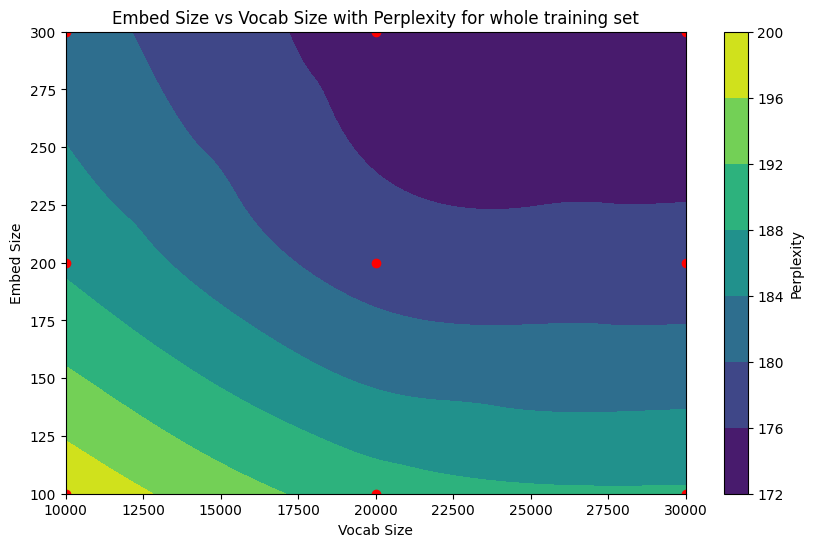

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Sample data
data = results

# Extracting data
vocab_size = [item['vocab_size'] for item in data if 'nano' not in item['train_file_path'] ]
embed_size = [item['embed_size'] for item in data if 'nano' not in item['train_file_path'] ]
perplexity = [item['perplexity'] for item in data if 'nano' not in item['train_file_path'] ]

# Plotting
grid_x, grid_y = np.meshgrid(np.linspace(min(vocab_size), max(vocab_size), 100),
                             np.linspace(min(embed_size), max(embed_size), 100))
grid_z = griddata((vocab_size, embed_size), perplexity, (grid_x, grid_y), method='cubic')

# Plotting
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, cmap='viridis')
plt.colorbar(contour, label='Perplexity')
plt.scatter(vocab_size, embed_size, c='red')  # Optional: plot actual data points
plt.xlabel('Vocab Size')
plt.ylabel('Embed Size')
plt.title('Embed Size vs Vocab Size with Perplexity for whole training set')
plt.show()

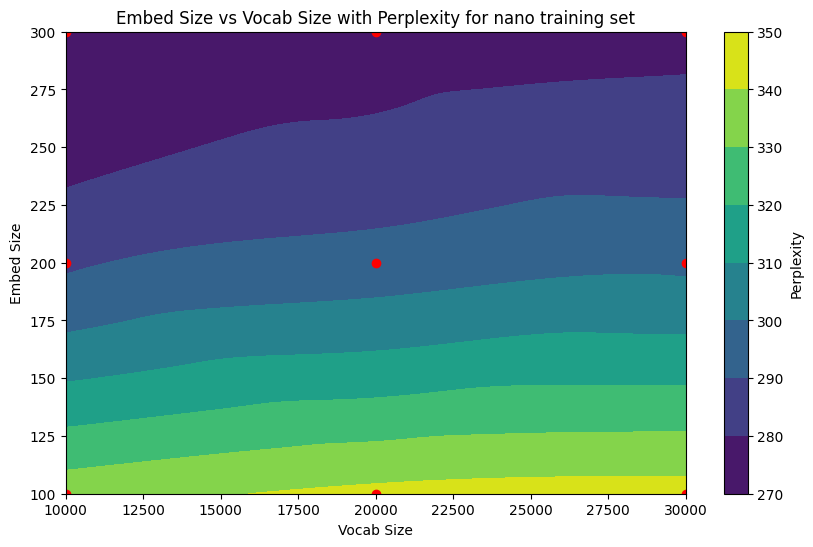

In [22]:
# Extracting data
vocab_size = [item['vocab_size'] for item in data if 'nano' in item['train_file_path'] ]
embed_size = [item['embed_size'] for item in data if 'nano' in item['train_file_path'] ]
perplexity = [item['perplexity'] for item in data if 'nano' in item['train_file_path'] ]

# Plotting
grid_x, grid_y = np.meshgrid(np.linspace(min(vocab_size), max(vocab_size), 100),
                             np.linspace(min(embed_size), max(embed_size), 100))
grid_z = griddata((vocab_size, embed_size), perplexity, (grid_x, grid_y), method='cubic')

# Plotting
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, cmap='viridis')
plt.colorbar(contour, label='Perplexity')
plt.scatter(vocab_size, embed_size, c='red')  # Optional: plot actual data points
plt.xlabel('Vocab Size')
plt.ylabel('Embed Size')
plt.title('Embed Size vs Vocab Size with Perplexity for nano training set')
plt.show()

In [26]:
from math import log

best_model_parameters = min(results, key=lambda x: x['perplexity'])
best_model_parameters['logPerplexity'] = log(best_model_parameters['perplexity'])
best_model_parameters

{'embed_size': 300,
 'vocab_size': 30000,
 'num_epochs': 1,
 'batch_size': 8192,
 'train_file_path': 'train/train.txt',
 'perplexity': 173.38,
 'logPerplexity': 5.155485717440494}